# Research Bandits

- This notebook analyses porfolio performance of 24 stocks from 2013 to 2023.
- The 24 stocks are selected dynamically every two weeks w.r.t to a group of clusters.
- The clusters are recreated every year w.r.t the 120-240 more performing stocks from the previous year.
That is for such simulation we take into consideration not the best performing stocks, but the ones that are between 120 and 240.

Note : In this notebook we consider 20 simulations per year in the bandit selection criteria

In [1]:
import os
import sys
path = '/'.join(os.path.abspath('').split('/')[0:-2])
print(path)
sys.path.append(path)

import pickle
import pandas as pd
import json
import random, tqdm
import numpy as np

from experts.alpha import alpha
from exploration.explore import explore
from exploration.outils import stats

import plotly.express as px

/home/mora/Documents/projects/Bandits


In [2]:
N_SIMS = 20

In [3]:
with open('../../../datasharing/tickers.json','r') as file:
    tickers = json.load(file)

tickers = tickers["sp500"]

In [4]:
# Load the pickle file that contains the full data for each stock
with open('../../../datasharing/hist_stock_data.pkl','rb') as file:
    df_hst_tickers = pickle.load(file)

# Chose the label "Close" as the main label to analyse the price series
label = 'Close'
df_close_stocks = pd.DataFrame([])
for key, df in df_hst_tickers.items():
    df_close_stocks = pd.concat([df_close_stocks,
                                 df[label]], axis = 1)

# Create a single data frame that cotains the series data from all the SP500 stocks
df_close_stocks.columns = list(df_hst_tickers.keys())
df_close_stocks['date'] = df_close_stocks.index
df_close_stocks.index = pd.to_datetime(df_close_stocks['date'])


df_close_stocks = pd.DataFrame()

for ticker in tickers:
    srs = df_hst_tickers[ticker][['Close']]
    srs.columns = [ticker]
    df_close_stocks = pd.concat([df_close_stocks,srs], axis = 1)
    
df_close_stocks.reset_index(inplace = True)
df_close_stocks['date'] = pd.to_datetime(df_close_stocks['Date'])

# Resample series in terms of 2Weeks
df_close_stocks.set_index('date', inplace = True)
df_2w = df_close_stocks.resample("2W").last()

In [17]:
import pdb

In [18]:
# Creating the function that compute the statistics
def get_stats(df_close_stocks, tickers: dict, years: list = None,
              inter = None, freq:str = 'M', min_els:int = 6) -> dict:
    """
    This function produces some statistics using a dataframe fille with stocks.
    Precisely the average mean return and the sharpe ratio.
    Args:
        df_hst_tickers (dict) - contains dataframes for multiple stocks
        tickers (list) - the list of tickers to compute the statistics 
        years (list) - the list of years to compute the statistics
        inter (slice) - A slice that precises the data indexs to compute the statistics
        freq (str) - the frequency for the statistics (Y,M,W,2W, ...)
        min_els(int) - the minimum quantity of elements in the series required
            after the frequency postprocessing.
    """
    st_stats = {}
    for ticker in tickers:
        if years:
            tmp_df = df_close_stocks[df_close_stocks['Date'].dt.year.isin(years)]
        elif inter:
            tmp_df = df_close_stocks.iloc[inter]

        pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()

        # discart ticket if not enough data
        if pc_m.shape[0] < min_els:
            continue
            
        av_ret = pc_m.mean()
        sr = av_ret / pc_m.std()
        st_stats[ticker] = {"sr":sr, 'av_ret':av_ret}
            
    return st_stats

def df_and_sort(st_stats: dict, col: str) -> pd.DataFrame :
    """
    Function that creates a dataframe using a dictionary of stocks with statistics
    metrics and sort the dataframe based on the column name precised.
    Args:
        st_stats (dict) - The dictionary containing the statistics.
        col (str) - The name of the column for sorting.
    """
    df_stats = pd.DataFrame(st_stats).transpose()
    df_stats.sort_values(by=col, inplace = True, ascending = False)
    return df_stats


def create_stock_groups(lst_stocks: list, basket_size: int,
                        max_stocks: int):
    """
    Create multiple group of stocks with basket_size elements
    inside each group.
    Args:
        lst_stocks (list) : List of stocks
        basket_size (int): The total element of stocks in
            each basket.
    """
    
    random.shuffle(lst_stocks)
    stcks = {'stocks_dict':list(lst_stocks), 'groups':{}}
    for i in range(0,max_stocks,basket_size):
        stcks['groups'].update({i:list(lst_stocks[i:i+basket_size])})
    
    return stcks


def simulate_year(df_series, years: list, n_sims: int,
                  stock_groups: dict, exploration_rate: float,
                  p_alpha: float):

    df_test = df_series[df_series['Date'].dt.year.isin(years)]
    lines = []

    for group, lst_stocks in stock_groups['groups'].items():

        df_bandits = df_test[lst_stocks].pct_change(1).dropna()

        if df_bandits.shape[0] == 0 or df_bandits.shape[1]==0:
            continue

        arguments = {"exploration_rate": exploration_rate,
                     "n_bandit":df_bandits.shape[1],
                     "steps":df_bandits.shape[0],
                     "alpha":p_alpha,
                     "df_bandits":df_bandits
                    }


        exp = explore(alpha.execute)
        exp.execute(n_sims, **arguments)
        mean, std = stats(exp.rets_compo)
        line = [arguments["alpha"],
                arguments["exploration_rate"],
                mean,
                std]

        lines.append(line)
        
    df_rets = pd.DataFrame(lines)
    df_rets.columns = ["alpha", "expl", "mean", "std"]
    
    return df_rets.mean()

In [22]:
# Create a group of stocks
min_stocks = 120
max_stocks = 240
stock_groups = {}
basket_size = 5
metric = 'sr' # choose between 'av_ret' or 'sr'

for year in tqdm.tqdm(range(2012,2024)):

    years_tr = list(range(year - 10, year))
    stats_tr = get_stats(df_close_stocks, tickers, years = years_tr)
    df_stats_tr = df_and_sort(stats_tr, metric)
    tst = df_stats_tr.index[min_stocks:max_stocks].values
    stock_groups[year] = create_stock_groups(tst,
                                             basket_size,
                                             min_stocks)
    print("year", stock_groups[year])

  0%|                                                    | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to 

/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m =

/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m =

year {'stocks_dict': ['DLTR', 'BDX', 'L', 'WDC', 'CLX', 'AAL', 'IFF', 'VFC', 'TJX', 'PCAR', 'UAL', 'PRU', 'PAYX', 'EMR', 'MMC', 'MOH', 'DTE', 'STE', 'PG', 'SJM', 'MTD', 'HST', 'UPS', 'AXON', 'DPZ', 'AMP', 'NDAQ', 'BR', 'POOL', 'FDS', 'PARA', 'RCL', 'AFL', 'ALB', 'BLK', 'MCK', 'AIZ', 'MPWR', 'EVRG', 'APH', 'CMI', 'LH', 'DGX', 'MHK', 'VLO', 'COST', 'KMB', 'HOLX', 'FE', 'BALL', 'STX', 'MAR', 'EXPD', 'WTW', 'FMC', 'ACN', 'AOS', 'EG', 'NRG', 'DVN', 'MCD', 'UNH', 'UHS', 'PLD', 'BKNG', 'PKG', 'CCI', 'ARE', 'PNC', 'HAS', 'DIS', 'APA', 'TECH', 'CE', 'COR', 'XOM', 'GPN', 'LVS', 'RJF', 'PXD', 'IEX', 'VRTX', 'HRL', 'REG', 'GOOGL', 'MSCI', 'FFIV', 'TDG', 'PNR', 'AJG', 'J', 'ROP', 'ADM', 'BEN', 'SRE', 'HAL', 'V', 'WST', 'CVX', 'GIS', 'CF', 'DE', 'GOOG', 'PEP', 'FDX', 'PGR', 'PPG', 'LYV', 'KIM', 'TEL', 'GPC', 'GL', 'EXC', 'MRO', 'CPB', 'USB', 'ZBH', 'BBWI', 'MTB', 'CI'], 'groups': {0: ['DLTR', 'BDX', 'L', 'WDC', 'CLX'], 5: ['AAL', 'IFF', 'VFC', 'TJX', 'PCAR'], 10: ['UAL', 'PRU', 'PAYX', 'EMR', 'MMC']

/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m =

/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m =

year {'stocks_dict': ['USB', 'BRO', 'RJF', 'CMCSA', 'HSIC', 'KIM', 'EG', 'AXON', 'EMR', 'DE', 'IEX', 'DG', 'PAYX', 'NDAQ', 'JNJ', 'L', 'HUM', 'FFIV', 'IRM', 'LUV', 'STX', 'DIS', 'TPR', 'HD', 'ALB', 'GPN', 'TJX', 'FDS', 'COP', 'TECH', 'NVR', 'J', 'KMB', 'IFF', 'DHR', 'LMT', 'DUK', 'PKG', 'HCA', 'DPZ', 'FMC', 'ATO', 'ITW', 'LNT', 'ARE', 'UAL', 'WDC', 'AAL', 'MAA', 'VRTX', 'NI', 'RL', 'TSLA', 'CTSH', 'CVS', 'APD', 'MTB', 'REGN', 'BAX', 'PXD', 'AZO', 'HON', 'BIO', 'BALL', 'MAR', 'AJG', 'WST', 'CSGP', 'HAL', 'AOS', 'PCAR', 'BBWI', 'VFC', 'GIS', 'PNC', 'EMN', 'DOV', 'BEN', 'PM', 'SBUX', 'STLD', 'MCK', 'MMM', 'PARA', 'OXY', 'MO', 'COR', 'HOLX', 'BLK', 'POOL', 'NRG', 'CF', 'SO', 'ES', 'QCOM', 'EQIX', 'WFC', 'MPWR', 'PNW', 'AES', 'WHR', 'EQT', 'CE', 'CVX', 'MOH', 'RMD', 'PGR', 'MRO', 'D', 'MHK', 'MMC', 'UDR', 'LRCX', 'ED', 'PLD', 'SNA', 'SYK', 'GL', 'TEL', 'IT'], 'groups': {0: ['USB', 'BRO', 'RJF', 'CMCSA', 'HSIC'], 5: ['KIM', 'EG', 'AXON', 'EMR', 'DE'], 10: ['IEX', 'DG', 'PAYX', 'NDAQ', 'JNJ']

/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m =

/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m =

year {'stocks_dict': ['BIO', 'BXP', 'MMM', 'CME', 'PEAK', 'DAL', 'K', 'GPN', 'WM', 'DG', 'FDS', 'OXY', 'CI', 'UDR', 'VTR', 'PNC', 'COST', 'CTSH', 'FRT', 'KDP', 'EL', 'HRL', 'JNJ', 'BAX', 'WELL', 'XEL', 'NFLX', 'STLD', 'AAL', 'GL', 'ALB', 'ULTA', 'RMD', 'IT', 'MCD', 'CPT', 'NI', 'UHS', 'PKG', 'CNC', 'HAL', 'BLK', 'DHR', 'NVR', 'MAR', 'T', 'MCHP', 'KMB', 'WMB', 'PXD', 'CAT', 'DPZ', 'WHR', 'META', 'EIX', 'VLO', 'IFF', 'PAYX', 'CF', 'ORCL', 'PANW', 'ES', 'TROW', 'MAA', 'LULU', 'HOLX', 'WFC', 'AVB', 'PARA', 'RL', 'CSGP', 'L', 'CNP', 'ED', 'APH', 'CBRE', 'FDX', 'EVRG', 'EQT', 'DOV', 'MRO', 'BRO', 'NOC', 'CL', 'SBUX', 'ITW', 'D', 'SO', 'SJM', 'HD', 'MHK', 'EMN', 'AIZ', 'VRTX', 'PWR', 'MCK', 'CVS', 'CMI', 'SYK', 'MPWR', 'AMZN', 'PH', 'HON', 'CMS', 'SPG', 'WDC', 'PM', 'LUV', 'LNT', 'IRM', 'ADM', 'HSIC', 'AVY', 'DTE', 'EQR', 'DIS', 'CVX', 'HAS', 'BEN', 'SLB'], 'groups': {0: ['BIO', 'BXP', 'MMM', 'CME', 'PEAK'], 5: ['DAL', 'K', 'GPN', 'WM', 'DG'], 10: ['FDS', 'OXY', 'CI', 'UDR', 'VTR'], 15: ['PNC

/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m =

 33%|██████████████▋                             | 4/12 [00:06<00:12,  1.50s/it]/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()


year {'stocks_dict': ['WM', 'WMB', 'EMR', 'CMI', 'EW', 'PLD', 'DG', 'T', 'EMN', 'RTX', 'KR', 'DLTR', 'SLB', 'GL', 'PH', 'AMP', 'ORCL', 'META', 'BLK', 'CPB', 'RMD', 'GIS', 'IRM', 'KLAC', 'CAT', 'TROW', 'AEE', 'KMB', 'SNPS', 'STLD', 'CVX', 'ISRG', 'GD', 'WFC', 'YUM', 'EVRG', 'ACN', 'PKG', 'TRMB', 'TEL', 'HD', 'SWKS', 'AAL', 'V', 'HAL', 'CBRE', 'ROK', 'AVB', 'WHR', 'MTD', 'TRV', 'XRAY', 'NFLX', 'DOV', 'KMX', 'ULTA', 'LULU', 'AJG', 'LOW', 'ALLE', 'MAA', 'JNJ', 'MTB', 'UHS', 'VTR', 'CNC', 'MNST', 'SCHW', 'NOC', 'MCHP', 'CVS', 'JBHT', 'MCD', 'DPZ', 'DAL', 'ARE', 'IT', 'IFF', 'MCK', 'PAYX', 'PEAK', 'IEX', 'CF', 'VFC', 'HON', 'STE', 'COST', 'HRL', 'CBOE', 'DHR', 'CCI', 'WST', 'UAL', 'L', 'AEP', 'MKTX', 'HLT', 'PNR', 'LRCX', 'FMC', 'NVR', 'LH', 'MPWR', 'BR', 'PNC', 'HAS', 'FSLR', 'UDR', 'MMM', 'WYNN', 'D', 'PXD', 'PM', 'APH', 'MAR', 'WDC', 'NUE', 'PWR', 'PARA', 'TMO'], 'groups': {0: ['WM', 'WMB', 'EMR', 'CMI', 'EW'], 5: ['PLD', 'DG', 'T', 'EMN', 'RTX'], 10: ['KR', 'DLTR', 'SLB', 'GL', 'PH'], 15

/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m =

year {'stocks_dict': ['AEE', 'EFX', 'DG', 'DHR', 'CLX', 'LLY', 'CMI', 'ANSS', 'LULU', 'AJG', 'VFC', 'ABT', 'APH', 'KIM', 'BBWI', 'BIIB', 'NSC', 'V', 'AON', 'DVA', 'AME', 'XRAY', 'BDX', 'UAL', 'DAL', 'TROW', 'PKG', 'CMCSA', 'PSX', 'REG', 'GL', 'EL', 'POOL', 'VZ', 'K', 'SBAC', 'SNPS', 'MTD', 'NDAQ', 'MMM', 'META', 'MTB', 'MKC', 'CINF', 'CNP', 'STLD', 'CHRW', 'CBRE', 'PWR', 'NOC', 'PM', 'DFS', 'CL', 'BMY', 'MHK', 'TRMB', 'IEX', 'PAYX', 'ITW', 'EMN', 'VTR', 'PXD', 'EOG', 'SJM', 'AAL', 'APD', 'PLD', 'T', 'WYNN', 'KLAC', 'LIN', 'JPM', 'HUBB', 'NUE', 'EIX', 'ABBV', 'JNJ', 'STE', 'PPG', 'PNC', 'SCHW', 'INCY', 'LOW', 'ARE', 'UHS', 'MCHP', 'JBHT', 'TECH', 'WM', 'RCL', 'HON', 'CSGP', 'SYK', 'DPZ', 'ROK', 'AMZN', 'ORCL', 'DOV', 'CE', 'VRTX', 'NFLX', 'MPWR', 'CBOE', 'IT', 'CNC', 'WHR', 'CVS', 'PNR', 'EMR', 'WDC', 'YUM', 'SBUX', 'KR', 'AMT', 'KMX', 'ISRG', 'PH', 'GD', 'CCI', 'WRB'], 'groups': {0: ['AEE', 'EFX', 'DG', 'DHR', 'CLX'], 5: ['LLY', 'CMI', 'ANSS', 'LULU', 'AJG'], 10: ['VFC', 'ABT', 'APH', 

/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m =

year {'stocks_dict': ['IQV', 'HII', 'ES', 'BXP', 'EIX', 'TEL', 'DIS', 'AEP', 'SBUX', 'EMR', 'BMY', 'DG', 'HAS', 'PPG', 'NFLX', 'TXN', 'CCI', 'TRV', 'VTR', 'TMO', 'STX', 'PLD', 'LRCX', 'CMG', 'CPB', 'AAPL', 'GD', 'SCHW', 'NOW', 'NUE', 'ILMN', 'PXD', 'HON', 'ICE', 'ANSS', 'DRI', 'HSIC', 'SNPS', 'CTAS', 'NVDA', 'PWR', 'IFF', 'RCL', 'MAA', 'LIN', 'ITW', 'LULU', 'ADI', 'ARE', 'PNR', 'IT', 'JNJ', 'UAL', 'META', 'TER', 'KLAC', 'EW', 'USB', 'JPM', 'AVB', 'MTB', 'MKC', 'PANW', 'V', 'TFC', 'AMAT', 'CLX', 'WHR', 'CBOE', 'LOW', 'APD', 'POOL', 'TRMB', 'CNC', 'EG', 'ECL', 'UHS', 'EMN', 'CMI', 'APH', 'MCD', 'BR', 'PEAK', 'DAL', 'TRGP', 'EFX', 'CAT', 'PM', 'INCY', 'TROW', 'DLTR', 'CNP', 'FRT', 'CHRW', 'COR', 'MCHP', 'NDAQ', 'YUM', 'STLD', 'ORCL', 'MHK', 'HRL', 'PH', 'CE', 'BRO', 'WST', 'MMM', 'MTD', 'WBA', 'IBM', 'AME', 'AMT', 'UPS', 'HAL', 'CSGP', 'DLR', 'DOV', 'AAL', 'RSG', 'FSLR'], 'groups': {0: ['IQV', 'HII', 'ES', 'BXP', 'EIX'], 5: ['TEL', 'DIS', 'AEP', 'SBUX', 'EMR'], 10: ['BMY', 'DG', 'HAS', 'P

/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m =

year {'stocks_dict': ['MNST', 'PHM', 'DHI', 'TXN', 'CLX', 'MCO', 'GNRC', 'ITW', 'CNC', 'APH', 'GPN', 'MAR', 'WMT', 'LEN', 'MU', 'XYL', 'FDX', 'KLAC', 'TROW', 'CHRW', 'ADI', 'DIS', 'CNP', 'GIS', 'EG', 'HON', 'YUM', 'BKNG', 'SWK', 'MHK', 'DAL', 'COO', 'USB', 'WDC', 'BLDR', 'STE', 'HWM', 'ALL', 'SPG', 'PLD', 'ROK', 'PAYC', 'EL', 'TRMB', 'ILMN', 'PAYX', 'TEL', 'ISRG', 'FITB', 'LKQ', 'AVY', 'AMAT', 'RCL', 'EMN', 'BR', 'MA', 'LOW', 'BIO', 'DRI', 'MO', 'TER', 'UPS', 'DLR', 'HII', 'SCHW', 'JBL', 'DOV', 'META', 'MTD', 'MKC', 'AMZN', 'CCI', 'VTR', 'WELL', 'V', 'PGR', 'PM', 'HSY', 'PPG', 'IDXX', 'AMGN', 'TDG', 'PSX', 'PANW', 'COST', 'COF', 'PH', 'AME', 'TRV', 'EW', 'MPWR', 'NFLX', 'JPM', 'AAL', 'PYPL', 'CAT', 'IFF', 'UHS', 'MCHP', 'WFC', 'POOL', 'TTWO', 'ABBV', 'PKG', 'UAL', 'KDP', 'WST', 'HUBB', 'SYK', 'EIX', 'HBAN', 'ORCL', 'NVDA', 'AVB', 'TMO', 'RSG', 'VRTX', 'GPC', 'FRT', 'PNC'], 'groups': {0: ['MNST', 'PHM', 'DHI', 'TXN', 'CLX'], 5: ['MCO', 'GNRC', 'ITW', 'CNC', 'APH'], 10: ['GPN', 'MAR', 'W

/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m =

year {'stocks_dict': ['REGN', 'UAL', 'TEL', 'STE', 'HUM', 'IT', 'STX', 'PEG', 'MCD', 'UNP', 'NDAQ', 'POOL', 'BA', 'ANSS', 'CLX', 'DHR', 'AAL', 'MTB', 'SBAC', 'HIG', 'TROW', 'SNA', 'LKQ', 'MAA', 'MNST', 'CBRE', 'TFC', 'AMCR', 'TMO', 'HBAN', 'TRMB', 'FITB', 'SCHW', 'RMD', 'AXP', 'PLD', 'NOW', 'YUM', 'EMN', 'EFX', 'FDS', 'DIS', 'SPG', 'PAYX', 'INTC', 'PYPL', 'EIX', 'IPG', 'NSC', 'LOW', 'LULU', 'CE', 'GRMN', 'LLY', 'INTU', 'PXD', 'ZBRA', 'NFLX', 'COST', 'RCL', 'RVTY', 'TSLA', 'FE', 'HUBB', 'ALGN', 'AVB', 'MKC', 'PH', 'MCHP', 'CMI', 'JBL', 'MSCI', 'PAYC', 'EQR', 'SO', 'VRSN', 'JBHT', 'BIO', 'ISRG', 'PSA', 'DXCM', 'GPN', 'AVY', 'IFF', 'DLR', 'OKE', 'DRI', 'ABBV', 'DAL', 'GPC', 'KEYS', 'TT', 'MCO', 'WELL', 'APD', 'PPG', 'SPGI', 'CHTR', 'PODD', 'JNJ', 'ANET', 'CMCSA', 'EL', 'UDR', 'CAT', 'DOV', 'FICO', 'IQV', 'BKNG', 'TER', 'ORCL', 'BRO', 'LUV', 'FFIV', 'KMB', 'AAPL', 'ITW', 'FIS', 'AMAT', 'WAT'], 'groups': {0: ['REGN', 'UAL', 'TEL', 'STE', 'HUM'], 5: ['IT', 'STX', 'PEG', 'MCD', 'UNP'], 10: ['

/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m =

year {'stocks_dict': ['EPAM', 'CAT', 'CMCSA', 'CDAY', 'ADP', 'LLY', 'PNC', 'TSLA', 'AAPL', 'PANW', 'MCHP', 'KDP', 'CMG', 'TT', 'EA', 'FITB', 'CME', 'BALL', 'SNA', 'HUBB', 'CI', 'BA', 'INVH', 'NXPI', 'YUM', 'ZTS', 'ABBV', 'FLT', 'LYB', 'MOH', 'INTC', 'DG', 'PKG', 'AMZN', 'RMD', 'REGN', 'BIO', 'PWR', 'JBHT', 'DLTR', 'FE', 'PSA', 'ALGN', 'LYV', 'FIS', 'META', 'UNP', 'TSCO', 'PSX', 'ABT', 'AXP', 'APD', 'ICE', 'MPWR', 'AMAT', 'JBL', 'SBAC', 'MAR', 'SWKS', 'UDR', 'TECH', 'CCI', 'MSFT', 'NDSN', 'NVDA', 'NFLX', 'VLO', 'ZBRA', 'MTB', 'ORCL', 'HBAN', 'WTW', 'MKC', 'BDX', 'DHR', 'AVY', 'HSY', 'AOS', 'CSX', 'AKAM', 'STE', 'OKE', 'EL', 'PODD', 'CPT', 'PPG', 'KEYS', 'PLD', 'CBOE', 'ANSS', 'LKQ', 'SYK', 'BKNG', 'TFC', 'ETSY', 'WELL', 'GPC', 'COST', 'ETR', 'TEL', 'ADI', 'EQIX', 'CHD', 'FDS', 'PH', 'ALLE', 'ADBE', 'KMB', 'INTU', 'ITW', 'TER', 'LHX', 'DOV', 'MCD', 'MSCI', 'AMCR', 'IT', 'NSC', 'FICO', 'RCL'], 'groups': {0: ['EPAM', 'CAT', 'CMCSA', 'CDAY', 'ADP'], 5: ['LLY', 'PNC', 'TSLA', 'AAPL', 'PANW']

/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m =

year {'stocks_dict': ['STX', 'FDS', 'DHI', 'INTC', 'ICE', 'EVRG', 'UNP', 'NFLX', 'ROK', 'APH', 'JNJ', 'DXCM', 'CRM', 'VFC', 'COO', 'ADSK', 'D', 'MTCH', 'NDSN', 'PG', 'KEYS', 'PKG', 'CTVA', 'ZTS', 'ES', 'TDG', 'TROW', 'ITW', 'ED', 'GWW', 'DOV', 'XYL', 'AMAT', 'MCHP', 'PHM', 'DUK', 'MCD', 'PEG', 'MKC', 'AME', 'AXON', 'ENPH', 'KDP', 'PLD', 'JBL', 'EA', 'TFX', 'ARE', 'ADI', 'DRI', 'MTD', 'HUBB', 'CNP', 'BALL', 'HPE', 'GL', 'IT', 'FTV', 'DFS', 'NXPI', 'DG', 'MDT', 'SCHW', 'NVR', 'GRMN', 'TT', 'HSY', 'EL', 'IQV', 'TEL', 'AXP', 'CCI', 'CLX', 'QRVO', 'BLK', 'CSCO', 'LHX', 'ZBRA', 'CBOE', 'AOS', 'JBHT', 'AZO', 'FLT', 'LW', 'RMD', 'CMG', 'CTLT', 'SNA', 'ROST', 'EFX', 'ULTA', 'ALGN', 'CMCSA', 'PH', 'WMT', 'CME', 'ADP', 'MOH', 'ABBV', 'ISRG', 'AMCR', 'HUM', 'CSX', 'META', 'FIS', 'DLR', 'REGN', 'HAS', 'BLDR', 'SWKS', 'TSCO', 'BIO', 'BDX', 'CI', 'PEP', 'JKHY', 'KMB', 'UPS', 'AVY', 'SO'], 'groups': {0: ['STX', 'FDS', 'DHI', 'INTC', 'ICE'], 5: ['EVRG', 'UNP', 'NFLX', 'ROK', 'APH'], 10: ['JNJ', 'DXCM',

/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m =

year {'stocks_dict': ['ADP', 'ILMN', 'BIO', 'CPT', 'IQV', 'EG', 'PEG', 'FIS', 'AXON', 'GPN', 'AKAM', 'DUK', 'CTVA', 'IT', 'CHD', 'ELV', 'AMD', 'TJX', 'CSCO', 'ROK', 'ES', 'SYK', 'DXCM', 'INTC', 'GWW', 'ZBRA', 'KDP', 'GOOG', 'AMT', 'GOOGL', 'DAL', 'STZ', 'VRTX', 'CME', 'JNJ', 'NSC', 'CSX', 'RVTY', 'XYL', 'MU', 'TDG', 'COO', 'PKG', 'CMCSA', 'HAS', 'LYV', 'FLT', 'ICE', 'ALGN', 'SO', 'URI', 'JPM', 'MOH', 'BDX', 'DHI', 'DOV', 'SBAC', 'PSA', 'DRI', 'AXP', 'SBUX', 'RJF', 'NDSN', 'BLK', 'UBER', 'META', 'JKHY', 'MS', 'AME', 'APTV', 'D', 'ED', 'UPS', 'MKC', 'HSY', 'AOS', 'ULTA', 'KEYS', 'CDAY', 'MCD', 'AEP', 'HIG', 'EVRG', 'MNST', 'ADI', 'AMCR', 'MSI', 'PHM', 'ALLE', 'NXPI', 'MAA', 'BAC', 'AON', 'CNC', 'RHI', 'JBHT', 'LOW', 'BK', 'ECL', 'KMB', 'PNW', 'UNP', 'AZO', 'PNC', 'FICO', 'ISRG', 'GNRC', 'MTCH', 'FITB', 'AFL', 'BALL', 'LEN', 'GL', 'HON', 'TEL', 'PEP', 'JBL', 'BSX', 'TSCO', 'ANSS'], 'groups': {0: ['ADP', 'ILMN', 'BIO', 'CPT', 'IQV'], 5: ['EG', 'PEG', 'FIS', 'AXON', 'GPN'], 10: ['AKAM', 'DU

/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()
/tmp/ipykernel_2801194/1320677068.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pc_m =

year {'stocks_dict': ['CNP', 'JPM', 'BAC', 'BK', 'STE', 'ULTA', 'A', 'COO', 'POOL', 'INTU', 'TSCO', 'STZ', 'PLD', 'PNC', 'RJF', 'SO', 'MKC', 'JKHY', 'ON', 'AXON', 'DG', 'NTAP', 'MTD', 'TT', 'MRK', 'ETSY', 'CNC', 'RHI', 'AMGN', 'UNP', 'AMD', 'BX', 'AVY', 'SBUX', 'IQV', 'SYY', 'HD', 'GOOGL', 'APD', 'MCHP', 'LW', 'AXP', 'PSA', 'SWKS', 'XYL', 'TJX', 'MAA', 'CBOE', 'COR', 'TYL', 'DHI', 'DRI', 'GWW', 'BLDR', 'ETR', 'APH', 'PFE', 'MS', 'HON', 'AMP', 'UPS', 'CMG', 'FI', 'ISRG', 'PFG', 'HPQ', 'AES', 'URI', 'ADI', 'CI', 'KEYS', 'JBL', 'AMCR', 'AMAT', 'DUK', 'DLTR', 'FITB', 'ACGL', 'PG', 'LOW', 'ES', 'NVR', 'KMB', 'AME', 'LDOS', 'JBHT', 'GIS', 'BLK', 'GPN', 'MOH', 'EQIX', 'BMY', 'DE', 'GOOG', 'DOV', 'ADP', 'PKG', 'ROP', 'BSX', 'EVRG', 'MCD', 'STLD', 'TECH', 'EPAM', 'WST', 'ICE', 'CSX', 'ITW', 'CHD', 'HPE', 'AKAM', 'CRM', 'ORCL', 'HII', 'FANG', 'WMT', 'RMD', 'TRV', 'MU', 'IT'], 'groups': {0: ['CNP', 'JPM', 'BAC', 'BK', 'STE'], 5: ['ULTA', 'A', 'COO', 'POOL', 'INTU'], 10: ['TSCO', 'STZ', 'PLD', 'PN

In [23]:
final_stats = []

for year in tqdm.tqdm(range(2012,2024)):
    for exploration_rate in np.arange(0.01,0.15,0.01):
        for p_alpha in np.arange(0.005,0.15,0.005):
            st_year = simulate_year(df_2w, [year], n_sims = N_SIMS,
                                    stock_groups = stock_groups[year],
                                    exploration_rate = exploration_rate,
                                    p_alpha = p_alpha
                                   )
            tmp_year = {"year":year,"ex_rate":exploration_rate,
                        "alpha":p_alpha, "return": st_year['mean']}
            final_stats.append(tmp_year)

100%|██████████████████████████████████████████| 12/12 [32:46<00:00, 163.89s/it]


In [24]:
df_res = pd.DataFrame(final_stats)
df_groups = df_res.groupby(by=['ex_rate','alpha']).mean()['return'].reset_index()

In [25]:
dict_perf = {}
for year in range(2012,2023):
    vals = df_res[df_res['year']==year].sort_values(by = 'return').iloc[-1].to_dict()
    dict_perf[year] = vals

In [26]:
dict_perf_nxt_y = {}
for year in range(2012,2023):
    alpha = dict_perf[year]['alpha']
    ex_rate = dict_perf[year]['ex_rate']
    perf_nxt = df_res[(df_res['year'] == year + 1 ) &\
               (df_res['alpha'] == alpha) &\
               (df_res['ex_rate'] == ex_rate)].iloc[0].to_dict()
    dict_perf_nxt_y[year+1] = perf_nxt

In [27]:
dict_perf_nxt_y

{2013: {'year': 2013.0,
  'ex_rate': 0.03,
  'alpha': 0.14,
  'return': 0.30331462661866226},
 2014: {'year': 2014.0,
  'ex_rate': 0.14,
  'alpha': 0.065,
  'return': 0.19267268316434408},
 2015: {'year': 2015.0,
  'ex_rate': 0.14,
  'alpha': 0.045,
  'return': 0.0670778645664077},
 2016: {'year': 2016.0,
  'ex_rate': 0.01,
  'alpha': 0.14,
  'return': 0.24506365464843585},
 2017: {'year': 2017.0,
  'ex_rate': 0.11,
  'alpha': 0.14500000000000002,
  'return': 0.2691902230097705},
 2018: {'year': 2018.0,
  'ex_rate': 0.02,
  'alpha': 0.034999999999999996,
  'return': -0.08938409002895377},
 2019: {'year': 2019.0,
  'ex_rate': 0.11,
  'alpha': 0.125,
  'return': 0.3860522090622979},
 2020: {'year': 2020.0,
  'ex_rate': 0.02,
  'alpha': 0.06,
  'return': 0.31807292671710413},
 2021: {'year': 2021.0,
  'ex_rate': 0.11,
  'alpha': 0.14,
  'return': 0.2503017768601641},
 2022: {'year': 2022.0,
  'ex_rate': 0.13,
  'alpha': 0.034999999999999996,
  'return': -0.10506665877267436},
 2023: {'yea

In [33]:
perf = pd.DataFrame(dict_perf_nxt_y).T

In [39]:
(perf[0:-2]['return'] + 1).cumprod()

2013    1.303315
2014    1.554428
2015    1.658695
2016    2.065181
2017    2.621108
2018    2.386823
2019    3.308261
2020    4.360529
2021    5.451977
Name: return, dtype: float64

In [35]:
com_ret = (perf['return'] + 1).cumprod()
com_ret_last = com_ret.iloc[-1]

<Axes: >

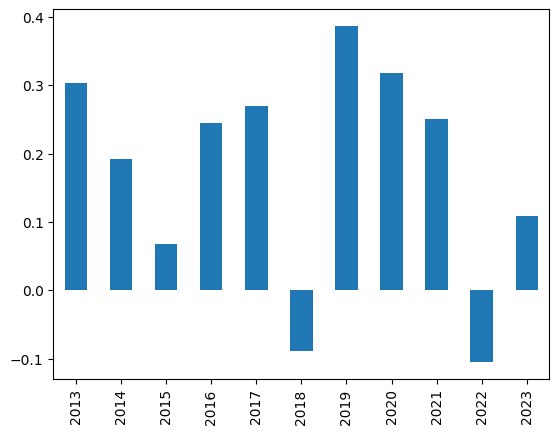

In [36]:
perf['return'].plot.bar()

In [37]:
N = 11 # number of years (2013 - 2023)
av_a_ret = (com_ret_last)**(1/N)

print("Return final year ", com_ret_last)
print("Average annual return ", av_a_ret)

Return final year  5.40918125992661
Average annual return  1.1658651520455217
